In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.76G/5.76G [02:14<00:00, 46.6MB/s]
100% 5.76G/5.76G [02:14<00:00, 46.1MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cassava-leaf-disease-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [5]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/train_images'
valid_path = '/content/test_images'

In [6]:
from tensorflow.keras.applications import ResNet50

# Load pre-trained ResNet50 model
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Set all layers as non-trainable
for layer in resnet.layers:
    layer.trainable = False


94765736/94765736 [==============================] - 3s 0us/step


In [7]:
#%% IMPORTING LIBRARIES

import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Defining the working directories

# work_dir = '/content/cassava-leaf-disease-classification.zip'
# os.listdir(work_dir)
train_path = '/content/train_images'

In [8]:
#%% IMPORTING DATA

# Importing train.csv

data = pd.read_csv('train.csv')
print(Counter(data['label'])) # Checking the frequencies of the labels

Counter({3: 13158, 4: 2577, 2: 2386, 1: 2189, 0: 1087})


In [9]:
# Importing the json file with labels

f = open(  'label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

# Defining the working dataset
data['class_name'] = data.label.map(real_labels)
print(data.head(10))
print(data['class_name'].unique())

         image_id  label                           class_name
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)
5  1000837476.jpg      3         Cassava Mosaic Disease (CMD)
6  1000910826.jpg      2           Cassava Green Mottle (CGM)
7  1001320321.jpg      0       Cassava Bacterial Blight (CBB)
8  1001723730.jpg      4                              Healthy
9  1001742395.jpg      3         Cassava Mosaic Disease (CMD)
['Cassava Bacterial Blight (CBB)' 'Cassava Mosaic Disease (CMD)'
 'Cassava Brown Streak Disease (CBSD)' 'Cassava Green Mottle (CGM)'
 'Healthy']


In [10]:
def showImages(images):

    # Extract 16 random images from it
    random_images = [np.random.choice(images) for i in range(16)]

    # Adjust the size of your images
    plt.figure(figsize=(16,12))

    # Iterate and plot random images
    for i in range(16):
        plt.subplot(4,4, i + 1)
        img = plt.imread(train_path+'/'+random_images[i])
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()

In [11]:
mask = data['label'] ==4
classHealthy = data[mask]

In [12]:
mask = data['label'] ==3
classCMD = data[mask]

In [13]:
mask = data['label'] ==2
classCGM = data[mask]

In [14]:
mask = data['label'] ==1
classCBSD = data[mask]

In [15]:
mask = data['label'] ==0
classCBB = data[mask]

In [16]:
class0 = classCBB.sample(frac=0.49)
class1 = classCBSD.sample(frac=0.49)
class2 = classCGM.sample(frac=0.49)
class3 = classCMD.sample(frac=0.49)
class4 = classHealthy.sample(frac=0.49)




frames=[class0,class1,class2,class3,class4]
finalData = pd.concat(frames)
finalData.head(10)
print(len(finalData))

10485


In [17]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Define necessary paths
train_path = '/content/train_images'
valid_path = '/content/test_images'

# Load data and define working directories
data = pd.read_csv('/content/train.csv')
with open('/content/label_num_to_disease_map.json') as f:
    real_labels = json.load(f)
real_labels = {int(k): v for k, v in real_labels.items()}
data['class_name'] = data.label.map(real_labels)

# Define working dataset and split data into train and validation sets
train, val = train_test_split(data, test_size=0.05, random_state=42, stratify=data['class_name'])

# Define image size
IMG_SIZE = (180,180)

# Define ImageDataGenerator with appropriate preprocessing function and image size
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

# Use correct target size in flow_from_dataframe
train_set = datagen.flow_from_dataframe(train,
                                        directory="/content/train_images",
                                        seed=42,
                                        x_col='image_id',
                                        y_col='class_name',
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        interpolation='nearest',
                                        shuffle=True,
                                        batch_size=32)

val_set = datagen.flow_from_dataframe(val,
                                      directory='/content/train_images',
                                      seed=42,
                                      x_col='image_id',
                                      y_col='class_name',
                                      target_size=IMG_SIZE,
                                      class_mode='categorical',
                                      interpolation='nearest',
                                      shuffle=True,
                                      batch_size=32)

resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define the loss function with label smoothing
loss = CategoricalCrossentropy(from_logits=False, label_smoothing=0.001, name='categorical_crossentropy')

# Compile the ResNet model with the defined optimizer, loss function, and metrics
resnet_model.compile(optimizer=Adam(learning_rate=2e-4),
              loss=loss,
              metrics=['categorical_accuracy'])

# Define early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)

# Save the best model based on validation loss
checkpoint_cb = ModelCheckpoint("ResNet_best_model.h5", save_best_only=True, monitor='val_loss', mode='min')

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, mode='min', verbose=1)

# Train the model with the defined callbacks
r = resnet_model.fit(train_set,
              validation_data=val_set,
              epochs=10,
              steps_per_epoch=len(train_set),
              validation_steps=len(val_set),
              callbacks=[es, checkpoint_cb, reduce_lr])



Found 20327 validated image filenames belonging to 5 classes.
Found 1070 validated image filenames belonging to 5 classes.
Epoch 1/10
636/636 [==============================] - ETA: 0s - loss: 1.1960 - categorical_accuracy: 0.6130

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


636/636 [==============================] - 341s 520ms/step - loss: 1.1960 - categorical_accuracy: 0.6130 - val_loss: 1.1712 - val_categorical_accuracy: 0.6150 - lr: 2.0000e-04
Epoch 2/10
636/636 [==============================] - 302s 475ms/step - loss: 1.1630 - categorical_accuracy: 0.6151 - val_loss: 1.1487 - val_categorical_accuracy: 0.6140 - lr: 2.0000e-04
Epoch 3/10
636/636 [==============================] - 299s 470ms/step - loss: 1.1573 - categorical_accuracy: 0.6153 - val_loss: 1.1443 - val_categorical_accuracy: 0.6150 - lr: 2.0000e-04
Epoch 4/10
636/636 [==============================] - 299s 471ms/step - loss: 1.1486 - categorical_accuracy: 0.6154 - val_loss: 1.1410 - val_categorical_accuracy: 0.6150 - lr: 2.0000e-04
Epoch 5/10
636/636 [==============================] - 302s 475ms/step - loss: 1.1386 - categorical_accuracy: 0.6159 - val_loss: 1.1305 - val_categorical_accuracy: 0.6150 - lr: 2.0000e-04
Epoch 6/10
636/636 [==============================] - 303s 476ms/step - loss

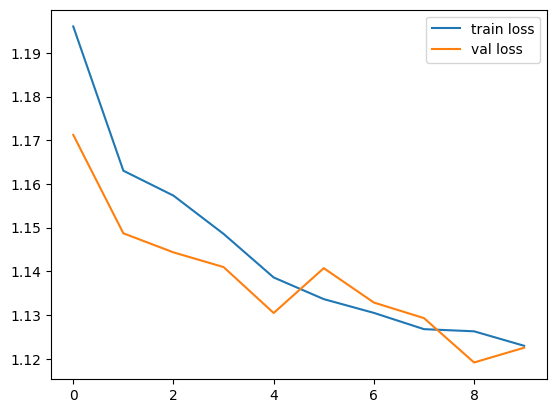

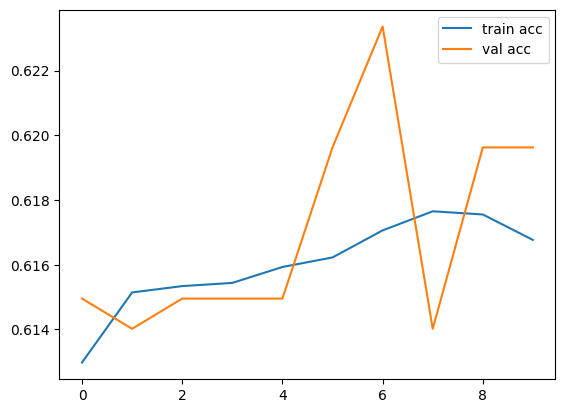

<Figure size 640x480 with 0 Axes>

In [20]:


# Plot the loss and accuracy graphs
import matplotlib.pyplot as plt

# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [21]:
from tensorflow.keras.models import load_model

resnet_model.save('model_resnet5.h5')

# y_pred = resnet_model.predict(validation_data)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
import glob

TEST_DIR = '/content/test_images'
test_images = glob.glob(os.path.join(TEST_DIR, "*.jpg")) + glob.glob(os.path.join(TEST_DIR, "*.png"))+ glob.glob(os.path.join(TEST_DIR, "*.jpeg"))
predictions = []
IMG_SIZE = 380
IMG_SIZE1 = 180
size = (IMG_SIZE,IMG_SIZE)
size1= (IMG_SIZE1,IMG_SIZE1)
for image in test_images:
    '''
    img = Image.open(TEST_DIR + image)
    img = img.resize(size)
    img = np.expand_dims(img, axis=0)
    prediction1 = final_model1.predict(img)
    print(prediction1)
    '''
    img1 = Image.open(os.path.join(TEST_DIR, image))
    img1 = img1.resize(size1)
    img1 = np.expand_dims(img1, axis=0)
    prediction2 = resnet_model.predict(img1)
    print(prediction2)
    #result = prediction1 + prediction2
    #print(result)
    #predictions.extend(result.argmax(axis = 1))
    predictions.extend(prediction2.argmax(axis = 1))

1/1 [==============================] - 2s 2s/step
[[0.7506246  0.18735227 0.0112165  0.00448474 0.04632195]]


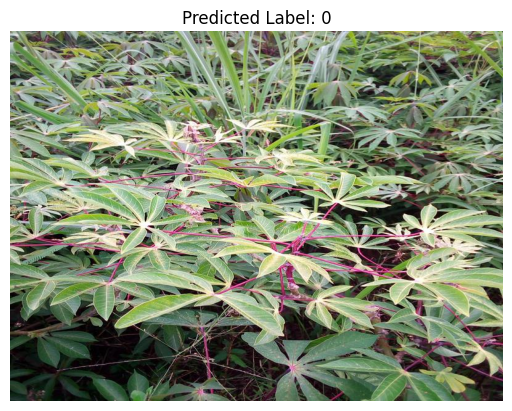

In [25]:
import matplotlib.pyplot as plt

# Assuming you have already imported necessary libraries and defined variables

# Iterate over each test image and its corresponding prediction
for image_path, prediction in zip(test_images, predictions):
    # Load and display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')

    # Set the title as the predicted label
    plt.title(f'Predicted Label: {prediction}')

    # Show the image with the predicted label
    plt.show()
